In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import time

from joblib import Parallel, delayed, cpu_count
from matplotlib import cm

# Methods

In [2]:
def box(x,xlim):
    if x>max(xlim):
        return max(xlim)
    elif x<min(xlim):
        return min(xlim)
    else:
        return x

In [4]:
def maxminoptimizer_eq12(x, y0, lambda0, tau, beta, epsilon=0.01):
    t = 0
    pg = 1000
    lambda_ = 0.1#lambda0
    y_ = y0
    while np.linalg.norm(pg) > epsilon:
        lamb = lambda_
        y = y_

        lambda_ = lamb + beta*(y - x)
        y_ = y - tau*(dgy(x,y) + lamb)

        lambda_ = max(lambda_, 0) # Lambda must always be positive

        pg = 1/beta*((lamb - lambda_) + (y-y_))
        t += 1
    return y, lamb

def maxminoptimizer_eq13(x, y0, lambda0, lambda_opt, gam, tau, beta, epsilon=0.01):
    t = 0
    pg = 1000
    lambda_ = lambda0
    y_ = y0
    while np.linalg.norm(pg) > epsilon:
        lamb = lambda_
        y = y_

        lambda_ = lamb + beta*(y - x)
        y_ = y - tau*(dfy(x,y) + gam*(dgy(x, y) ) + lamb)

        lambda_ = max(lambda_, 0) # Lambda must always be positive

        pg = 1/beta*((lamb - lambda_) + (y-y_))
        t += 1
    return y, lamb

def solveF(x0,y0,lambda0,alpha,gam,beta,tau,xlim,epsilon=0.01,max_iters=10000):
    ls=[]
    pg = 1000
    pgs=[]
    x_ = box(x0,xlim)
    y_g = y0
    k=0
    
    xs = []
    ys = []
    lambdas = []

    dfxs = []
    dgxs_yf = []
    dgxs_yg = []

    while np.linalg.norm(pg) > epsilon and k < max_iters:
        x=x_
        y=y_g
        
        y_g, lambda_g = maxminoptimizer_eq12(x, y, lambda0, tau, beta, epsilon)
        y_F, lambda_F = maxminoptimizer_eq13(x, y_g, lambda0, lambda_g, gam, tau, beta, epsilon)
        
        dF = dfx(x,y_F)

        dfxs.append(dF)
                
        x_ = box(x-alpha*(dF + gam*(dgx(x, y_F) - dgx(x, y_g) + lambda_g) - lambda_F),xlim)
        dgxs_yf.append(dgx(x, y_F))
        dgxs_yg.append(dgx(x, y_g))
        pg=1/alpha*np.array([x-x_,y-y_g])
        
        pgs.append(float(np.linalg.norm(pg)))
        ls.append(float(np.abs(y+x)))

        xs.append(x_)
        ys.append(y_g)
        lambdas.append(lambda_g)
        k+=1
    return (x,y,k), (pgs, ls, xs, ys, lambdas), (dfxs, dgxs_yf, dgxs_yg)

In [5]:
def run_exp(i, gam, beta, tau, alpha,epsilon=1e-4):

    x=np.random.uniform(0,3.5)
    y=np.random.uniform(-5,8.5)
    lamb = np.random.uniform(0, 10)
    
    try:
        (x,y,k), _, _ = solveF(x,y,lamb,alpha,gam,beta,tau,xlim,epsilon,max_iters=500)
    except OverflowError:
        x = -1
        y = -1
        k = -1

    return x, y, k

# Toy example 1

In [3]:
def g(x, y):
    return (y-2*x)**2

def dgx(x,y):
    return -4*(y-2*x)

def dgy(x,y):
    return 2*(y-2*x)

def dg(x,y):
    return np.array([dgx(x,y), dgy(x,y)])

def f(x,y):
    return math.exp(-y+2)/(2+math.cos(4*x))+0.5*math.log((4*x-2)**2+1) + x**2

def f_np(x,y):
    return np.exp(-y+2)/(2+np.cos(4*x))+0.5*np.log((4*x-2)**2+1) + x**2

def dfx(x,y):
    return 4*math.exp(-y+2)*math.sin(4*x)/((2+math.cos(4*x))**2)+(16*x-8)/((4*x-2)**2+1) + 2*x

def dfy(x,y):
    return -math.exp(-y+2)/(2+math.cos(4*x))

def df(x,y):
    return np.array([dfx(x,y), dfy(x,y)])

In [6]:
xlim = [0., 3.] # this is set C

In [7]:
n_jobs = cpu_count()
N = 200
gamma = 5
beta = .1
tau = .1
alpha = .01
results = Parallel(n_jobs=n_jobs)(delayed(run_exp)(i, gamma, beta, tau, alpha) for i in range(N))

ps = np.array(results)

Text(0.5, 0, 'Number of iterations needed until convergence')

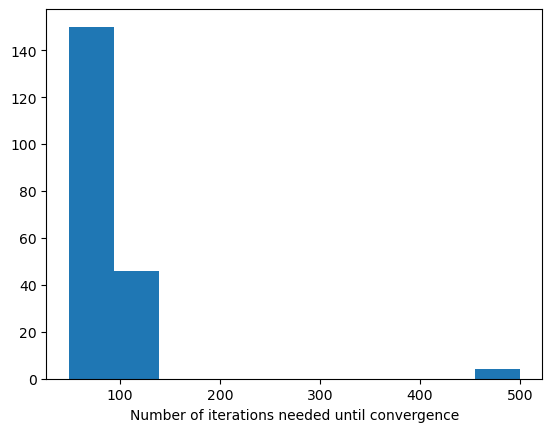

In [8]:
plt.hist(ps[:,2])
plt.xlabel("Number of iterations needed until convergence")

(array([ 2.,  4.,  6.,  8., 10., 12.]),
 [Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10'),
  Text(0, 12.0, '12')])

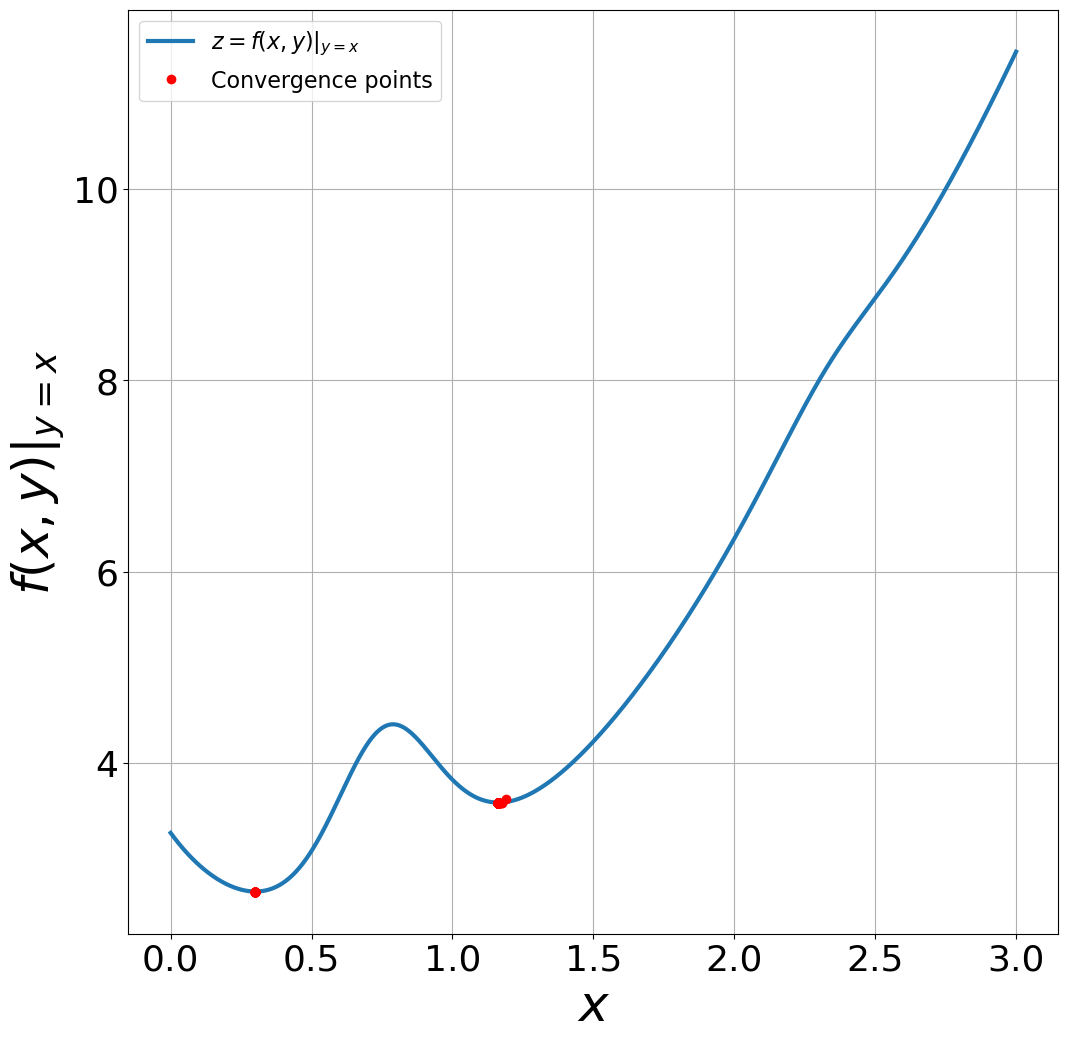

In [9]:
x_ax = np.linspace(0, 3, 1000)

plt.figure(figsize=(12,12))
plt.plot(x_ax, f_np(x_ax,x_ax), linewidth=3)
for i in range(N):
    plt.plot(ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r')

plt.legend(['$z=f(x,y)|_{y=x}$', 'Convergence points'], fontsize=16)
plt.grid()
plt.xlabel('$x$', fontsize=36)
plt.ylabel('$f(x,y)|_{y=x}$', fontsize=36)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

Text(0.5, 0, '$x$')

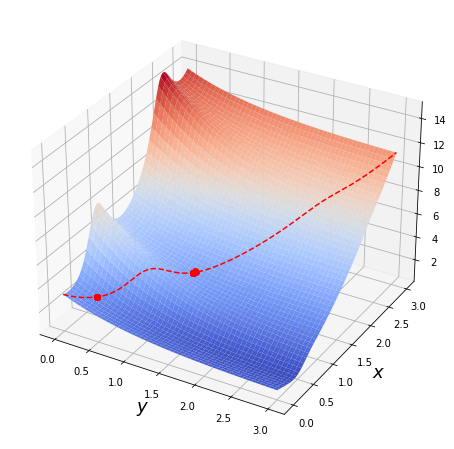

In [10]:
Xx = np.linspace(0,3,1000)
Yy = np.linspace(0,3,1000)
X, Y = np.meshgrid(Xx, Yy)
Z = f_np(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,8))
surf = ax.plot_surface(Y,X, Z, cmap=cm.coolwarm, alpha=1.)#, rstride=1, cstride=1)

ax.plot(Xx, Xx, f_np(Xx, Xx), 'r--', zorder=10)

for i in range(n_jobs):
    ax.plot(ps[i,1], ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r', zorder=10)

ax.set_xlabel("$y$", fontsize=18)
ax.set_ylabel("$x$", fontsize=18)

# Toy example 2

In [11]:
def f(x,y):
    return np.exp(-y+2)/(2+np.cos(6*x))+0.5*np.log((4*x-2)**2+1)# + x**2

def f_np(x,y):
    return np.exp(-y+2)/(2+np.cos(6*x))+0.5*np.log((4*x-2)**2+1)# + x**2

def dfx(x,y):
    return 6*math.exp(-y+2)*math.sin(6*x)/((2+math.cos(6*x))**2)+(16*x-8)/((4*x-2)**2+1)# + 2*x

def dfy(x,y):
    return -math.exp(-y+2)/(2+math.cos(6*x))

def df(x,y):
    return np.array([dfx(x,y), dfy(x,y)])

In [12]:
n_jobs = cpu_count()
N = 200
gamma = 5
beta = .1
tau = .1
alpha = .01
results = Parallel(n_jobs=n_jobs)(delayed(run_exp)(i, gamma, beta, tau, alpha) for i in range(N))

ps = np.array(results)

Text(0.5, 0, 'Number of iterations needed until convergence')

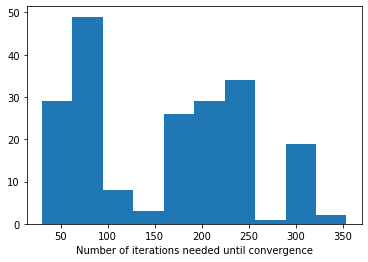

In [13]:
plt.hist(ps[:,2])
plt.xlabel("Number of iterations needed until convergence")

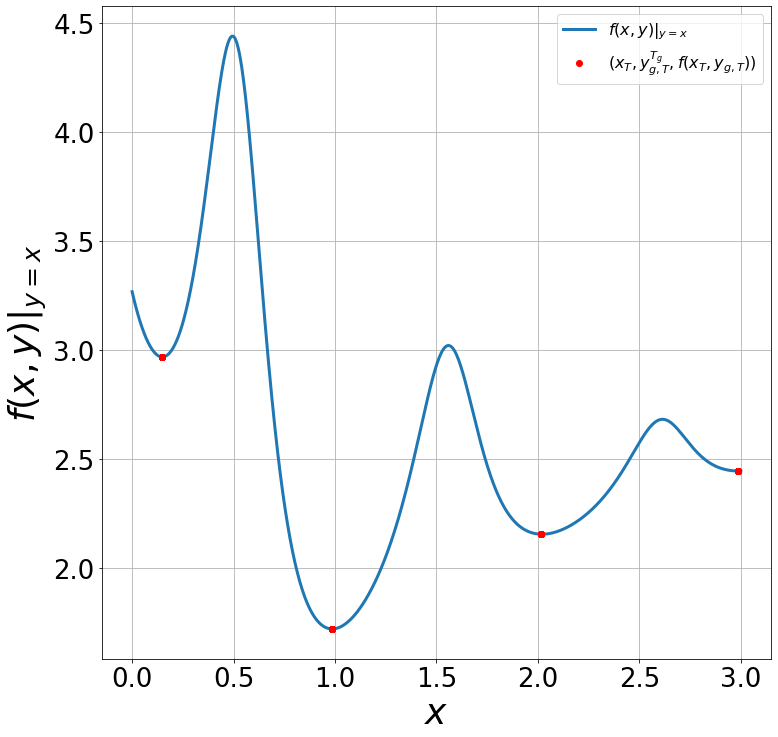

In [15]:
x_ax = np.linspace(0, 3, 1000)

plt.figure(figsize=(12,12))
plt.plot(x_ax, f_np(x_ax,x_ax), linewidth=3)
for i in range(N):
    plt.plot(ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r')

plt.legend(['$f(x,y)|_{y=x}$', '$(x_T, y^{T_g}_{g,T}, f(x_T, y_{g,T}))$'], fontsize=16)
plt.grid()
plt.xlabel('$x$', fontsize=36)
plt.ylabel('$f(x,y)|_{y=x}$', fontsize=36)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.savefig('results/toy/convergence.pdf')

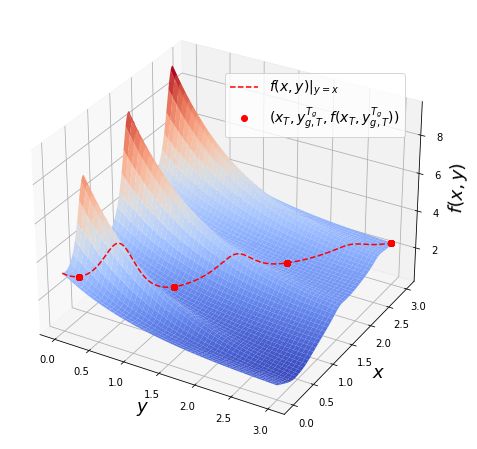

In [16]:
Xx = np.linspace(0,3,1000)
Yy = np.linspace(0,3,1000)
X, Y = np.meshgrid(Xx, Yy)
Z = f_np(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,8))
surf = ax.plot_surface(Y,X, Z, cmap=cm.coolwarm, alpha=1.)#, rstride=1, cstride=1)

ax.plot(Xx, Xx, f_np(Xx, Xx), 'r--', zorder=10, label="$f(x,y)|_{y=x}$")

for i in range(n_jobs):
    if i == 1:
        ax.plot(ps[i,1], ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r', zorder=10, label="$(x_T, y^{T_g}_{g,T}, f(x_T, y^{T_g}_{g,T}))$")
    else:
        ax.plot(ps[i,1], ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r', zorder=10)

ax.set_xlabel("$y$", fontsize=18)
ax.set_ylabel("$x$", fontsize=18)
ax.set_zlabel("$f(x,y)$", fontsize=18)

ax.legend(loc=(0.5,0.7), fontsize=14)

plt.savefig('results/toy/3dplot.pdf', bbox_inches="tight")